<a href="https://colab.research.google.com/github/positivejmk/Tobigs_17/blob/main/Tobigs_Week7_nlp_basic_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP 기초 Assignment
## NLP 맛보기 - spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [1]:
# colab 환경에서 python glove를 사용하기 위해 pip로 install

! pip install glove-python-binary

     |████████████████████████████████| 948 kB 4.1 MB/s 


In [2]:
# 필요한 모듈 불러오기
import gensim
from gensim.models import Word2Vec, FastText
from glove import Corpus, Glove
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load Data
- 보시면 아시다시피 spam.csv는 라벨이 있는 데이터입니다. 물론 7주차 주제가 텍스트 기초인만큼 텍스트만 활용하셔도 되고, 라벨까지 활용하셔서 모델을 돌려보셔도 좋습니다 :)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# 사용할 코퍼스의 경로
dir = '/content/drive/MyDrive/Colab Notebooks/Tobigs_17/Week7_NLP/'
path = dir + 'Data_wordEmbedding/wiki_small800.txt'

In [14]:
spam = pd.read_csv(dir + 'spam.csv')

In [15]:
spam.head(6)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...


In [16]:
spam.iloc[5]['v2']

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

In [19]:
# 특수 문자 제거 및 소문자로 변경
import re

def cleanText(data):
  text = re.sub('[^a-zA-Z]', ' ', data).lower()
  return text

spam.v2 = spam.v2.apply(cleanText)

In [20]:
spam.iloc[5]['v2']

'freemsg hey there darling it s been   week s now and no word back  i d like some fun you up for it still  tb ok  xxx std chgs to send         to rcv'

## Tokenizing


In [8]:
import nltk

# 예시 코드 코드
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords') # nltk에 저장되어 있는 불용어를 불러온다.
english_stops = list(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
tk_test = spam.copy()

In [24]:
token = []

for sentence in tk_test.v2 : 
    words = word_tokenize(sentence) 
    words = [word for word in words if word not in english_stops] # 불용어 제거
    token.append(words)
    
tk_test.v2 = token

In [26]:
tk_test

,v1,v2
0,ham,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,"[ok, lar, joking, wif, u, oni]"
2,spam,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"[nah, think, goes, usf, lives, around, though]"
...,...,...
5567,spam,"[nd, time, tried, contact, u, u, pound, prize,..."
5568,ham,"[b, going, esplanade, fr, home]"
5569,ham,"[pity, mood, suggestions]"
5570,ham,"[guy, bitching, acted, like, interested, buyin..."


In [35]:
tk_test.v1 = spam.v1.replace(['ham','spam'],[0,1])
tk_test

,v1,v2
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, think, goes, usf, lives, around, though]"
...,...,...
5567,1,"[nd, time, tried, contact, u, u, pound, prize,..."
5568,0,"[b, going, esplanade, fr, home]"
5569,0,"[pity, mood, suggestions]"
5570,0,"[guy, bitching, acted, like, interested, buyin..."


## Embedding

- 수업에서 다룬 임베딩 방법에는 One-hot encoding, CBOW, Skip-gram, GloVe, FastText, EMlo가 있었습니다. 다양한 시도와 '비교' 결과를 함께 적어주세요! 파라미터를 조정해가는 과정도 해석에 도움이 될 수 있겠죠 :)

### 1. One-hot encoding

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
# ham

ct_vector1 = CountVectorizer(max_features = 500, stop_words = 'english', lowercase = False)
corpus_ham = sum(tk_test[tk_test.v1 == 0]['v2'], [])
ct_ham = ct_vector1.fit_transform(corpus_ham)

In [37]:
count_ham = pd.DataFrame( {'word' : ct_vector1.get_feature_names(),
                           'count' : ct_ham.sum(axis = 0).flat})
count_ham.sort_values('count', ascending = False).head(10) # 빈도수가 높은 단어 상위 10개 추출

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,word,count
161,gt,318
247,lt,316
300,ok,287
157,got,245
453,ur,241
215,know,236
155,good,233
232,like,232
68,come,228
84,day,216


In [38]:
# spam

ct_vector2 = CountVectorizer(max_features= 500, stop_words = 'english', lowercase= False)
corpus_spam = sum(tk_test[tk_test.v1 == 1]['v2'], []) 
ct_spam = ct_vector2.fit_transform(corpus_spam)

In [39]:
count_spam = pd.DataFrame( {'word' : ct_vector2.get_feature_names(),
                           'count' : ct_spam.sum(axis = 0).flat})
count_spam.sort_values('count', ascending = False).head(10) # 빈도수가 높은 단어 상위 10개 추출

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,word,count
147,free,228
436,txt,170
446,ur,144
252,mobile,129
411,text,126
392,stop,126
65,claim,113
343,reply,104
486,www,98
320,prize,93


#### Word2Vec

> skip-gram

In [44]:
# spam training
model = Word2Vec(tk_test[tk_test.v1 == 1]['v2'], min_count = 5, size = 100, window = 2, iter = 200, sg = 1)
model.save('w2v_model_spam')

In [45]:
w2v_model_spam = Word2Vec.load('w2v_model_spam')

In [49]:
# 유사도가 없는 단어 추출
w2v_model_spam.wv.doesnt_match("free txt ut stop mobile text claim reply www prize".split())

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'mobile'

스팸의 상위 10개 단어들 중 가장 유사도가 낮은 단어는 mobile 이다.

In [47]:
w2v_model_spam.wv.most_similar('free')

[('minutes', 0.41114112734794617),
 ('tomorrow', 0.3998676538467407),
 ('stoptxt', 0.3777744174003601),
 ('half', 0.37513601779937744),
 ('true', 0.3699318766593933),
 ('tariffs', 0.35876137018203735),
 ('entitled', 0.3559296727180481),
 ('sipix', 0.3514840006828308),
 ('linerental', 0.3471612334251404),
 ('comp', 0.34704452753067017)]

free 와 가장 유사한 단어는 minutes, tomorrow 등 이 있다.

In [48]:
w2v_model_spam.most_similar(positive=['free', 'prize'], negative= ['ok'], topn=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sipix', 0.3445214033126831),
 ('sony', 0.3410695791244507),
 ('linerental', 0.3354026675224304),
 ('th', 0.3326329290866852),
 ('digital', 0.3132900297641754),
 ('sonyericsson', 0.3062112629413605),
 ('either', 0.3024734854698181),
 ('delivery', 0.29497602581977844),
 ('tomorrow', 0.29369568824768066),
 ('nd', 0.29117971658706665)]

In [51]:
# ham training
model2 = Word2Vec(tk_test[tk_test.v1 == 0]['v2'], min_count=5, size=100, window=2, iter=200, sg=1) 

In [52]:
model2.save('w2v_model_ham')

In [53]:
w2v_model_ham = Word2Vec.load('w2v_model_ham')

In [54]:
w2v_model_ham.wv.doesnt_match("gt lt ok got know like good come ur time".split())

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'come'

정상 메일 빈도수 상위 10개 단어 중 가장 유사도가 낮은 단어는 come이다.

In [55]:
w2v_model_ham.wv.most_similar('ok')

[('sed', 0.44058459997177124),
 ('cuz', 0.40676140785217285),
 ('problem', 0.40031927824020386),
 ('uni', 0.3846803903579712),
 ('ard', 0.37218913435935974),
 ('mood', 0.3681231737136841),
 ('mm', 0.358272910118103),
 ('din', 0.3559080958366394),
 ('minute', 0.3535616099834442),
 ('hi', 0.3453512191772461)]

gt, lt를 제외한 해석이 가능한 가장 높은 빈도를 보인 단어인 ok기준으로 유사도를 구하면, sed-cuz-problem 등이 높게 나오는 것을 확인할 수 있음.

In [57]:
w2v_model_ham.most_similar(positive=['ok', 'like'], negative= ['free'], topn=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('body', 0.3308146595954895),
 ('hour', 0.3154008984565735),
 ('worse', 0.31327536702156067),
 ('oops', 0.31011462211608887),
 ('alright', 0.2988033592700958),
 ('joke', 0.281642884016037),
 ('seems', 0.2805437445640564),
 ('sunny', 0.27616697549819946),
 ('takes', 0.2735947370529175),
 ('twice', 0.2722897231578827)]

> CBOW

In [58]:
# spam training

model = Word2Vec(tk_test[tk_test.v1 == 1]['v2'], min_count=5, size=100, window=2, iter=200, sg=0)

In [59]:
model.save('w2v_model_cbow_spam')

In [60]:
w2v_cbow_spam = Word2Vec.load('w2v_model_cbow_spam')

In [61]:
w2v_cbow_spam.wv.doesnt_match("free txt ut stop mobile text claim reply www prize".split())

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'claim'

스팸 메일의 상위 빈도수 10가지 단어 중 가장 유사도가 낮은 단어는 claim이었다.

In [62]:
w2v_cbow_spam.wv.most_similar('free')

[('get', 0.42847949266433716),
 ('st', 0.3777228593826294),
 ('phones', 0.3632518947124481),
 ('minutes', 0.35917359590530396),
 ('latest', 0.3498082458972931),
 ('may', 0.3388518691062927),
 ('tomorrow', 0.3317992091178894),
 ('plus', 0.33009442687034607),
 ('unlimited', 0.32197004556655884),
 ('gb', 0.30743172764778137)]

free와 유사한 단어는 get, phones, minutes, latest 등이 뽑혔다.

In [63]:
# ham training
model2 = Word2Vec(tk_test[tk_test.v1 == 0]['v2'], min_count=5, size=100, window=2, iter=200, sg=0)

In [64]:
model2.save('w2v_cbow_ham')

In [65]:
w2v_cbow_ham = Word2Vec.load('w2v_cbow_ham')

In [67]:
w2v_cbow_ham.wv.doesnt_match("gt lt ok got know like good come ur time".split())

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'come'

정상 메일의 상위 빈도수 단어 10개 중 유사도가 가장 낮은 단어는 come이었다.

In [68]:
w2v_cbow_ham.wv.most_similar('ok')

[('home', 0.3791886568069458),
 ('ard', 0.35876211524009705),
 ('anything', 0.3291126489639282),
 ('din', 0.3055838346481323),
 ('plans', 0.2900446653366089),
 ('cuz', 0.2840474545955658),
 ('worry', 0.2804642617702484),
 ('uni', 0.2715291976928711),
 ('coffee', 0.26678386330604553),
 ('mah', 0.25697657465934753)]

ok와 유사한 단어로는 home - anything -  plans - cuz - worry 등이 있었다.

</br>
</br>

## 본인이 도출해낸 해석을 적어주세요!

- 유사도, Wordcloud, 이진 분류 모델, Plot 뭐든 상관없으니 분명하고 인상적인 해석을 적어주시면 됩니다.

<function matplotlib.pyplot.show>

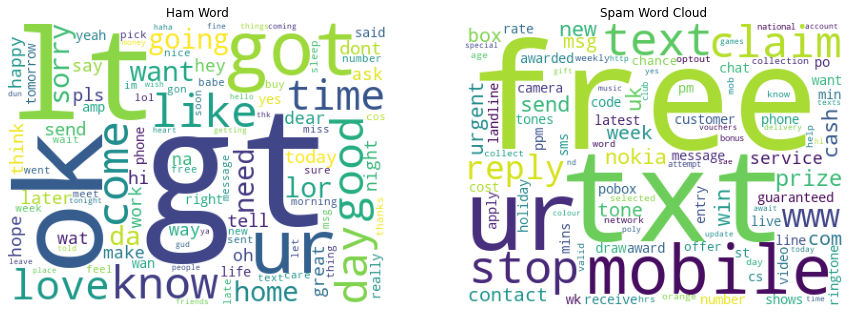

In [69]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', max_words=100, width = 400, height = 300)

plt.figure(figsize = (15,10))

plt.subplot(1,2,1)
plt.title('Ham Word')
count_dic = dict(zip(count_ham['word'], count_ham['count']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)

plt.subplot(1,2,2)
plt.title('Spam Word Cloud')
count_dic = dict(zip(count_spam['word'], count_spam['count']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)


plt.show

일반 정상메일과 달리 스팸 광고메일은 확실히 free가 가장 빈번했으며, 사용자들의 특정한 행위를 유도하는 claim, txt, mobile, www(url주소에서 추출되었음을 추정) 등이 빈번하게 나타났음을 확인. 

> spam 결과 비교

In [72]:
w2v_model_spam.wv.most_similar('free')

[('minutes', 0.41114112734794617),
 ('tomorrow', 0.3998676538467407),
 ('stoptxt', 0.3777744174003601),
 ('half', 0.37513601779937744),
 ('true', 0.3699318766593933),
 ('tariffs', 0.35876137018203735),
 ('entitled', 0.3559296727180481),
 ('sipix', 0.3514840006828308),
 ('linerental', 0.3471612334251404),
 ('comp', 0.34704452753067017)]

In [74]:
w2v_cbow_spam.wv.most_similar('free')

[('get', 0.42847949266433716),
 ('st', 0.3777228593826294),
 ('phones', 0.3632518947124481),
 ('minutes', 0.35917359590530396),
 ('latest', 0.3498082458972931),
 ('may', 0.3388518691062927),
 ('tomorrow', 0.3317992091178894),
 ('plus', 0.33009442687034607),
 ('unlimited', 0.32197004556655884),
 ('gb', 0.30743172764778137)]

광고성 메일에 액션을 독촉하는 기한인 minutes, tomorrow 가 둘 다 도출된 것은 유의미한 결과라고 생각된다. 이 외에도 latest, plus, unlimited 등 보다 스팸성 메일과 관련성이 높아보이는 단어를 추출한 것은 cbow라고 생각된다.

In [70]:
w2v_model_ham.wv.most_similar('ok')

[('sed', 0.44058459997177124),
 ('cuz', 0.40676140785217285),
 ('problem', 0.40031927824020386),
 ('uni', 0.3846803903579712),
 ('ard', 0.37218913435935974),
 ('mood', 0.3681231737136841),
 ('mm', 0.358272910118103),
 ('din', 0.3559080958366394),
 ('minute', 0.3535616099834442),
 ('hi', 0.3453512191772461)]

In [71]:
w2v_cbow_ham.wv.most_similar('ok')

[('home', 0.3791886568069458),
 ('ard', 0.35876211524009705),
 ('anything', 0.3291126489639282),
 ('din', 0.3055838346481323),
 ('plans', 0.2900446653366089),
 ('cuz', 0.2840474545955658),
 ('worry', 0.2804642617702484),
 ('uni', 0.2715291976928711),
 ('coffee', 0.26678386330604553),
 ('mah', 0.25697657465934753)]

ok와 유사도가 높은 home, anything, plans, worry, coffee 등 일상적인 단어가 많이 등장한 cbow가 더 합리적인 것으로 보인다. skip-gram의 결과는 1) 해석이 어렵거나 광고,비광고성 메일에서도 너무 일반적인 단어들이 많이 등장했으며 2) 앞서 스팸메일의 'free'와 유사도가 높았던 'minute'단어가 정상메일의 'ok' 단어에서도 유사도가 높은 것으로 나타났기에 사용이 어려울 것으로 보인다.

따라서 최종 모델로 cbow를 채택한다.